In [52]:
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
from mpl_toolkits import mplot3d as mpl3d
from scipy import signal, stats, linalg, fft

# import our 'specsens' package with the help of 'sys'
import sys
sys.path.insert(0, '..')
import specsens as ss

In [53]:
# general settings for signal and noise
sample_freq = 1e6  # in Hz
length = 0.01024  # in s
signal_power = 1.0  # in dB
noise_power = 21.0  # in dB

# create the signal (the 'soft speaker' kind)
wm = ss.WirelessMicrophone(f_sample=sample_freq, t_sec=length, seed=None)
sig = wm.soft(f_center=-1e5, power=signal_power, dB=True)
sig += wm.soft(f_center=-2e5, power=signal_power+2, dB=True)
sig += wm.soft(f_center=1e5, power=signal_power-3, dB=True)
sig += wm.soft(f_center=2e5, power=signal_power+3, dB=True)

# create the noise
wgn = ss.WhiteGaussianNoise(f_sample=sample_freq, t_sec=length, seed=None)
noise = wgn.signal(power=noise_power, dB=True)

# ensure noise and signal have same length (and create global variable 'num_samples')
assert wm.num_samples == wgn.num_samples
num_samples = wm.num_samples

# create actual signal ('both') comprising of signal and additive white Gaussian noise (AWGN)
both = sig + noise
# both = noise

# print some info about signal and noise
print('Signal power: %.2f dB' % (ss.util.signal_power(sig, dB=True)))
print('Noise power:  %.2f dB' % (ss.util.signal_power(noise, dB=True)))
print('SNR:          %.2f dB' % (ss.util.snr(sig, noise, dB=True)))
print('Num samples:  %d' % (num_samples))

# ensure that Parseval's theorem holds
ss.util.check_parseval(both, length, sample_freq)

Signal power: 8.06 dB
Noise power:  20.99 dB
SNR:          -12.93 dB
Num samples:  10240


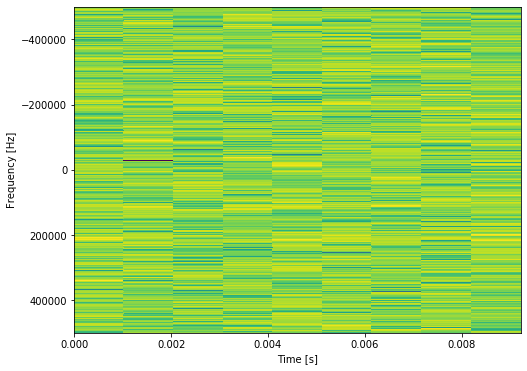

In [54]:
# use the 2d plot function to plot the spectogram
ss.spectrum_plot_2d(sig=both,
                    f_sample=sample_freq,
                    window='flattop',
                    nfft=1024)

100%|██████████| 10220/10220 [00:00<00:00, 181867.42it/s]


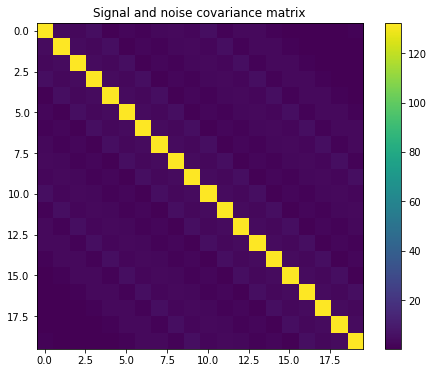

In [55]:
# covariance matrices
cov_size = 20

plt.figure(figsize=(8, 6))
mat_both = ss.eigen_detector.corr(x=both, l=cov_size)
plt.imshow(np.abs(mat_both))
plt.colorbar()
plt.title('Signal and noise covariance matrix')
plt.show()

N 10240 L 20 c 0.001953125


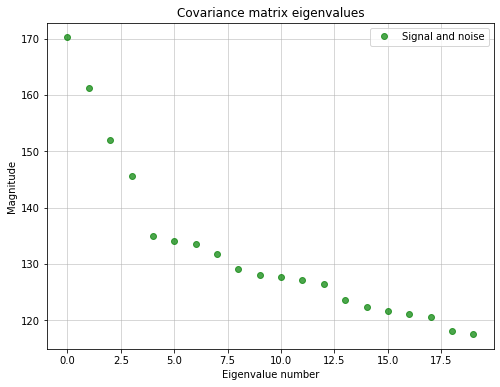

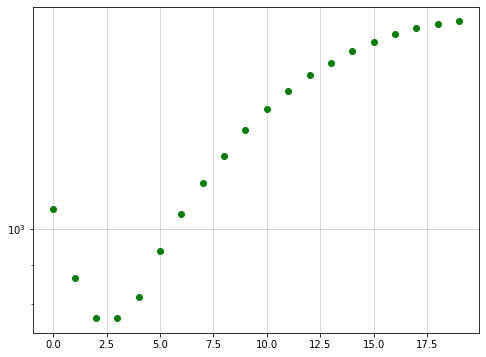

optM 2
act 125.89254117941675
est 128.62674683540092


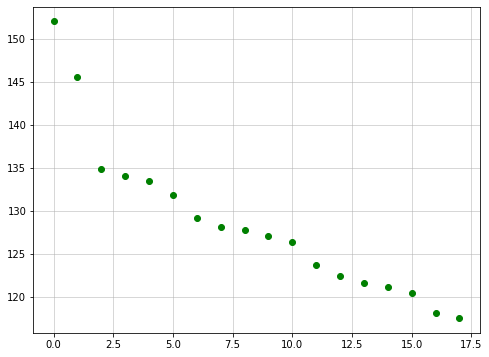

In [56]:
N = num_samples
L = cov_size
c = L/N
print('N', N, 'L', L, 'c', c)

both_eig_vals = np.sort(np.abs(linalg.eigvals(mat_both)))[::-1]

plt.figure(figsize=(8, 6))
plt.plot(both_eig_vals, 'go', alpha=0.7, aa=True, label='Signal and noise')
plt.xlabel(r'Eigenvalue number')
plt.ylabel(r'Magnitude')
plt.grid(linewidth=0.5)
plt.title('Covariance matrix eigenvalues')
plt.legend(loc=0)
plt.show()

def mdl(L, N, eigs, M):
    eigs = eigs[M:]
    prod = np.prod(eigs**(1 / (L - M)))
    summ = np.sum(eigs) / (L - M)
    return -(L - M) * N * np.log(
        prod / summ) + .5 * M * (2 * L - M) * np.log(N)

x = list(range(L))
y = list(map(lambda x: mdl(L, N, both_eig_vals, x), x))

plt.figure(figsize=(8, 6))
plt.plot(y, 'go')
plt.grid(linewidth=0.5)
plt.yscale('log')
plt.show()

M = np.argmin(y)
print('optM', M)


m_eigs = both_eig_vals[M:]
print('act', ss.util.dB_to_factor_power(noise_power))
print('est', np.mean(m_eigs))


plt.figure(figsize=(8, 6))
plt.plot(m_eigs, 'go')
plt.grid(linewidth=0.5)
plt.show()

beta 0.1


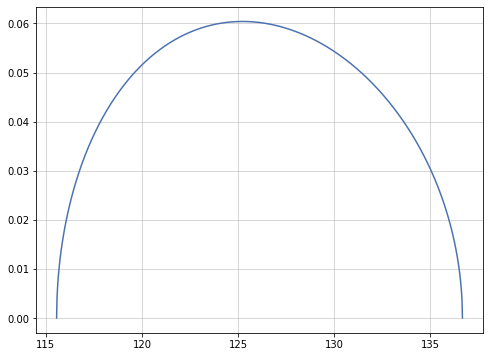

In [57]:
# L - total matrix size
# M - number of signal eigenvalues
# N - number of samples
# eigs - list of sorted eigenvalues

beta = M / L
print('beta', beta)

def marchenko_pastur_pdf(var, c, res):
    v_max, v_min = var * (1 + c**.5)**2., var * (1 - c**.5)**2.
    v = np.linspace(v_min, v_max, res)
    return v, ((v - v_min) * (v_max - v))**.5 / (2. * np.pi * var * v * c)

v, mp = marchenko_pastur_pdf(ss.util.dB_to_factor_power(noise_power), (1-beta)*c, res=1000)



# kde = stats.gaussian_kde(m_eigs).evaluate(v)

plt.figure(figsize=(8, 6))
plt.plot(v, mp)
# plt.hist(m_eigs, bins=cov_size//2, density=True)
plt.grid(linewidth=0.5)
plt.show()

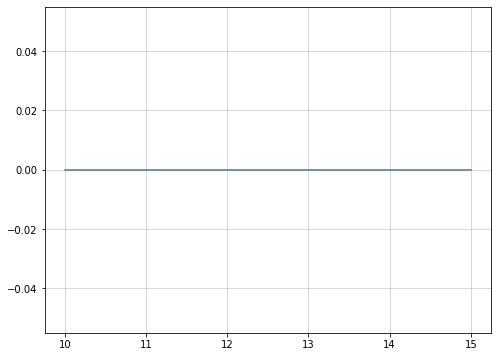

In [58]:
def marchenko_pastur_pdf(var, c, v):
    v_max, v_min = var * (1 + c**.5)**2., var * (1 - c**.5)**2.
    if v > v_max or v < v_min:
        return 0
    else:
        return ((v - v_min) * (v_max - v))**.5 / (2. * np.pi * var * v * c)
    
x = np.linspace(10, 15, 1000)
y = list(map(lambda x: marchenko_pastur_pdf(ss.util.dB_to_factor_power(noise_power), (1-beta)*c, x), x))

plt.figure(figsize=(8, 6))
plt.plot(x, y)
plt.grid(linewidth=0.5)
plt.show()

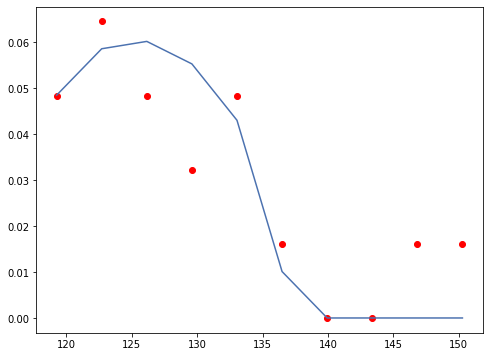

In [59]:
y_hist, x_hist = np.histogram(m_eigs, bins=cov_size//2, density=True)
x_hist = (x_hist + np.roll(x_hist, -1))[:-1] / 2.0

y_mp = list(map(lambda x: marchenko_pastur_pdf(ss.util.dB_to_factor_power(noise_power), (1-beta)*c, x), x_hist))

plt.figure(figsize=(8, 6))
plt.plot(x_hist, y_hist, 'ro')
plt.plot(x_hist, y_mp)
plt.show()

smalles eig 117.54971171022277
115.80431203344682 153.3416999052535


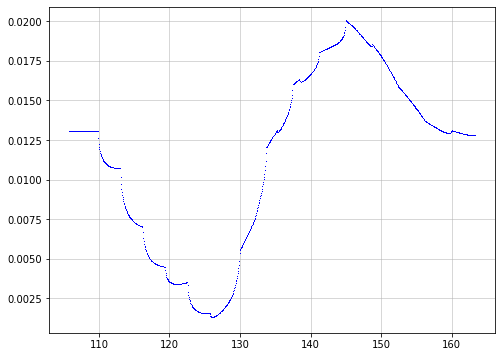

act 125.89254117941675
est 128.62674683540092
opt 126.07774599828761


-56.64695435072793

In [60]:
def two_sigmas(c, eigs):
    print('smalles eig', eigs[-1])
    l1 = eigs[-1] / (1 - c**.5)**2 * .9
    l2 = eigs[0] / (1 + c**.5)**2 * 1.1
    return l1, l2

pi1, pi2 = two_sigmas(c, m_eigs)

print(pi1, pi2)
pis = np.linspace(pi1-10, pi2+10, 1000)

def diff(var, x, y):
    mp = list(map(lambda x: marchenko_pastur_pdf(var, (1-beta)*c, x), x))
    return np.sum(np.power(mp - y, 2.0))
    
diffs = list(map(lambda x: diff(x, x_hist, y_hist), pis))

plt.figure(figsize=(8, 6))
plt.plot(pis, diffs, 'b,')
plt.grid(linewidth=0.5)
plt.show()

print('act', ss.util.dB_to_factor_power(noise_power))
print('est', np.mean(m_eigs))
print('opt', pis[np.argmin(diffs)])

ss.util.dB((abs(ss.util.dB_to_factor_power(noise_power)-pis[np.argmin(diffs)]))/ss.util.dB_to_factor_power(noise_power))